<a href="https://colab.research.google.com/github/BhaskarBiswas/Python-Codes/blob/master/classification_algo_with_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Problem
To reduce the number of fraud transactions keeping the transactions rate high.

## Objective
To predict/flag whether a future transaction will be fraud or not.

## Data Source
https://www.kaggle.com/ananta/credit-card-data

## Execution Platform
Python notebook



In [1]:
# Importing the libraries
#pip install imblearn
import os
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import imblearn
from imblearn.over_sampling import SMOTE
seed = 100

In [2]:
# Getting the name of different sheets in excel
df = pd.ExcelFile('CreditCardData.xlsx')
print(df.sheet_names)

['TransactionBase', 'FraudBase', 'CardBase', 'CustomerBase']


In [3]:
list_of_dfs = {}
for i in df.sheet_names:
    list_of_dfs['df_'+i] = pd.read_excel('CreditCardData.xlsx', sheet_name=i)
    print("--------------------------------------------------")
    print('data name:  ','df_'+i)
    print(list_of_dfs['df_'+i].shape)
    print(list_of_dfs['df_'+i].dtypes)
    print(list(list_of_dfs['df_'+i]))

--------------------------------------------------
data name:   df_TransactionBase
(10000, 5)
Transaction_ID                 object
Transaction_Date       datetime64[ns]
Credit_Card_ID                 object
Transaction_Value               int64
Transaction_Segment            object
dtype: object
['Transaction_ID', 'Transaction_Date', 'Credit_Card_ID', 'Transaction_Value', 'Transaction_Segment']
--------------------------------------------------
data name:   df_FraudBase
(109, 2)
Transaction_ID    object
Fraud_Flag         int64
dtype: object
['Transaction_ID', 'Fraud_Flag']
--------------------------------------------------
data name:   df_CardBase
(500, 4)
Card_Number     object
Card_Family     object
Credit_Limit     int64
Cust_ID         object
dtype: object
['Card_Number', 'Card_Family', 'Credit_Limit', 'Cust_ID']
--------------------------------------------------
data name:   df_CustomerBase
(5674, 4)
Cust_ID                   object
Age                        int64
Customer_Segm

In [4]:
list_of_dfs.keys()

dict_keys(['df_TransactionBase', 'df_FraudBase', 'df_CardBase', 'df_CustomerBase'])

## Data Preparation
The data is prepared at a transaction level joining the fraud, card and customer-base data to the trasaction data

Filling the NA while joining with fraud flag with zero indicating that the transactions which is not in the Fraud list are not fraud transactions

In [5]:
data_temp_1 = list_of_dfs['df_TransactionBase'].merge(list_of_dfs['df_FraudBase'], on=['Transaction_ID'], how='left').fillna(0)

data_temp_2 = list_of_dfs['df_CardBase'].merge(list_of_dfs['df_CustomerBase'], on=['Cust_ID'], how='left')
df_master = data_temp_1.merge(data_temp_2, left_on=['Credit_Card_ID'], right_on=['Card_Number'], how='left')
df_master = df_master[['Transaction_ID', 'Transaction_Date', 'Cust_ID', 'Credit_Card_ID',
                       'Transaction_Value', 'Transaction_Segment', 'Fraud_Flag', 'Card_Family', 
                       'Credit_Limit', 'Age', 'Customer_Segment', 'Customer_Vintage_Group']]


In [6]:
df_master.columns


Index(['Transaction_ID', 'Transaction_Date', 'Cust_ID', 'Credit_Card_ID',
       'Transaction_Value', 'Transaction_Segment', 'Fraud_Flag', 'Card_Family',
       'Credit_Limit', 'Age', 'Customer_Segment', 'Customer_Vintage_Group'],
      dtype='object')

## Data Understanding

In [7]:
# Size of data (number of rows and number of columns)
df_master.shape


(10000, 12)

In [8]:
# See the top 5 rows from the dataframe
df_master.head(5)

,Transaction_ID,Transaction_Date,Cust_ID,Credit_Card_ID,Transaction_Value,Transaction_Segment,Fraud_Flag,Card_Family,Credit_Limit,Age,Customer_Segment,Customer_Vintage_Group
0,CTID28830551,2016-04-24,CC24544,1629-9566-3285-2123,23649,SEG25,0.0,Platinum,194000,23,Gold,VG3
1,CTID45504917,2016-02-11,CC62261,3697-6001-4909-5350,26726,SEG16,0.0,Gold,15000,48,Gold,VG3
2,CTID47312290,2016-11-01,CC99402,5864-4475-3659-1440,22012,SEG14,0.0,Gold,2000,23,Diamond,VG1
3,CTID25637718,2016-01-28,CC14871,5991-4421-8476-3804,37637,SEG17,0.0,Gold,19000,44,Platinum,VG2
4,CTID66743960,2016-03-17,CC11165,1893-8853-9900-8478,5113,SEG14,0.0,Premium,417000,42,Gold,VG3


In [9]:
# Check the column names and their data type
df_master.dtypes

Transaction_ID                    object
Transaction_Date          datetime64[ns]
Cust_ID                           object
Credit_Card_ID                    object
Transaction_Value                  int64
Transaction_Segment               object
Fraud_Flag                       float64
Card_Family                       object
Credit_Limit                       int64
Age                                int64
Customer_Segment                  object
Customer_Vintage_Group            object
dtype: object

In [10]:
# Changing the datatype for objects to string 
for i in df_master.select_dtypes(['object']).columns:
    df_master[i] = df_master[i].astype('str')

In [11]:
# Getting the count of unique values for each column
col_list = df_master.columns.values
for col in col_list:
    print("Unique values in", col, len(df_master[col].unique()))

Unique values in Transaction_ID 10000
Unique values in Transaction_Date 366
Unique values in Cust_ID 482
Unique values in Credit_Card_ID 500
Unique values in Transaction_Value 9035
Unique values in Transaction_Segment 15
Unique values in Fraud_Flag 2
Unique values in Card_Family 3
Unique values in Credit_Limit 293
Unique values in Age 31
Unique values in Customer_Segment 3
Unique values in Customer_Vintage_Group 3


From the above output, we can see that we have 10000 distinct values for Transaction ID, 482 distinct values for customer ID, 500 distinct values for Card Number, and so on. We see that, there are multiple cards for a single customer ID.

In [12]:
# A quick glimpse to all the integer (or float) variables
df_master.describe()

,Transaction_Value,Fraud_Flag,Credit_Limit,Age
count,10000.000000,10000.000000,10000.000000,10000.00000
mean,24758.741300,0.010900,250839.600000,35.57120
std,14371.088758,0.103838,268729.432371,8.74669
min,103.000000,0.000000,2000.000000,20.00000
25%,12317.500000,0.000000,35000.000000,28.00000
50%,24720.500000,0.000000,140000.000000,36.00000
75%,37036.250000,0.000000,406000.000000,43.00000
max,49995.000000,1.000000,899000.000000,50.00000


## Feature enginnering (adding derived variables)
Adding variable:

* Number of cards for each customer
* No of transactions by each customer
* Days of transaction by each customer
* Created dummy variables for Customer_Segment and Card_Family variables

In [13]:
check_1 =  (list_of_dfs['df_CardBase']).groupby('Cust_ID').agg({'Card_Number':'count'}).reset_index().rename(columns={'Card_Number': 'No_of_Cards'})
check_2 = df_master.groupby('Cust_ID').agg({'Transaction_ID':'count'}).reset_index().rename(columns={'Transaction_ID': 'Cnt_of Trans'})
check_3 = (df_master[['Cust_ID', 'Transaction_Date']].drop_duplicates()).groupby(['Cust_ID']).agg({'Transaction_Date':'count'}).reset_index().rename(columns={'Transaction_Date': 'Cnt_of Trans_dt'})

In [14]:
df_master = df_master.merge(check_1, on=['Cust_ID'], how='left')
df_master = df_master.merge(check_2, on=['Cust_ID'], how='left')
df_master = df_master.merge(check_3, on=['Cust_ID'], how='left')
df_master['Perc_Credit_Used'] = round(df_master['Transaction_Value'] / df_master['Credit_Limit'], 2)
df_master['No_of_Cards'] = np.where(df_master['No_of_Cards']==2, 1, 0)


In [15]:
df_master['Card_Family_G'] = np.where(df_master['Card_Family'] == 'Gold', 1, 0)
df_master['Card_Family_Pr'] = np.where(df_master['Card_Family'] == 'Premium', 1, 0)
df_master['Customer_Segment_G'] = np.where(df_master['Customer_Segment'] == 'Gold', 1, 0)
df_master['Customer_Segment_Pr'] = np.where(df_master['Customer_Segment'] == 'Premium', 1, 0)

## Data Cleaning (Missing value and Outlier treatment)

In [16]:
df_master[['Customer_Segment', 'Customer_Vintage_Group']].drop_duplicates()


,Customer_Segment,Customer_Vintage_Group
0,Gold,VG3
2,Diamond,VG1
3,Platinum,VG2


These two variables have 1-1 mapping, so we can drop any of these two.


In [17]:
df_master = df_master.drop(columns='Customer_Vintage_Group')


## Missing value treatment

In [18]:
# Getting the number of missing values for each column
pd.DataFrame(df_master.isna().sum()).reset_index()

,index,0
0,Transaction_ID,0
1,Transaction_Date,0
2,Cust_ID,0
3,Credit_Card_ID,0
4,Transaction_Value,0
5,Transaction_Segment,0
6,Fraud_Flag,0
7,Card_Family,0
8,Credit_Limit,0
9,Age,0


There is no missing value as the NA generated while joining with fraud flag to transaction data is replaced with zero earlier

## Outlier treatment
Checking the size of data and column names before outlier treatment

In [19]:
print('shape of the master data: ',df_master.shape)

shape of the master data:  (10000, 19)


In [20]:
df_master.columns

Index(['Transaction_ID', 'Transaction_Date', 'Cust_ID', 'Credit_Card_ID',
       'Transaction_Value', 'Transaction_Segment', 'Fraud_Flag', 'Card_Family',
       'Credit_Limit', 'Age', 'Customer_Segment', 'No_of_Cards',
       'Cnt_of Trans', 'Cnt_of Trans_dt', 'Perc_Credit_Used', 'Card_Family_G',
       'Card_Family_Pr', 'Customer_Segment_G', 'Customer_Segment_Pr'],
      dtype='object')

For outlier treatment, we are calculating the Q1, Q3 and Inter-Quartile Range (IQR). 

Then, we are capping values which are less than (Q1 - 1.5 * IQR) or greater than (Q3 + 1.5 * IQR).

In [21]:
def outliers(data, feature_var):
    for i in feature_var:
        q1 = data[i].quantile(.25)
        q3 = data[i].quantile(.75)
        IQR = q3-q1
        lb = q1-(1.5*IQR)
        ub = q3+(1.5*IQR)
        combinations = [data[i]<lb, data[i]>ub]
        values = [lb,ub]
        data[i] = np.select(combinations, values, default=data[i])
    return data
features = ['Transaction_Value', 'Credit_Limit', 'Age', 'Cnt_of Trans', 'Cnt_of Trans_dt', 'Perc_Credit_Used']
df_master = outliers(df_master, features)
print(df_master.shape)

(10000, 19)


In [22]:
df_master['Age'].min()

20.0

In [23]:
df_master['Age'].max()

50.0

In [24]:
df_master[df_master['Perc_Credit_Used']>1]['Fraud_Flag'].value_counts()

0.0    1604
1.0      18
Name: Fraud_Flag, dtype: int64

We see that some of the customers are exceeding their credit limit in a single transaction. So we are capping the percentage credit used.

In [25]:
df_master['Perc_Credit_Used'] = np.where(df_master['Perc_Credit_Used']>1, 1, df_master['Perc_Credit_Used'])

Here, we can see that the data does not have any outlier.

## Exploratory Data Analysis (EDA)

In [26]:
df_master['Fraud_Flag'].value_counts(sum)

0.0    0.9891
1.0    0.0109
Name: Fraud_Flag, dtype: float64

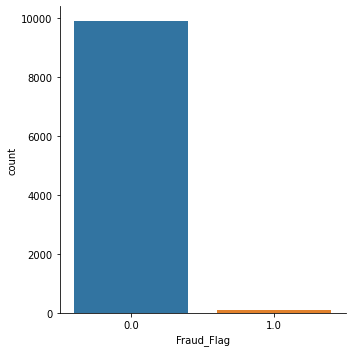

In [27]:
sns.catplot(x="Fraud_Flag", kind="count", data=df_master)

Checking the proportion of 0 and 1 in fraud flag. We can see this is an unbalanced problem with less than 1% of 1 and 99% of 0s.

Next, we are checking the distribution of different variable across y variable (Fraud_Flag)

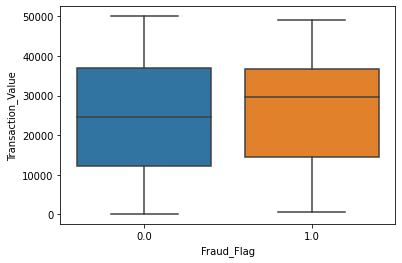

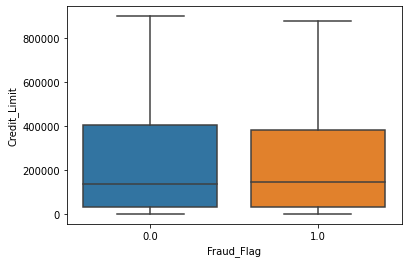

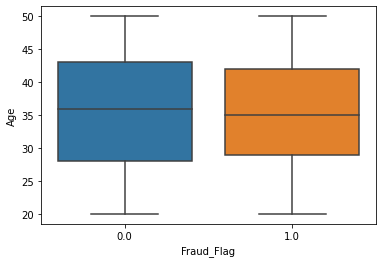

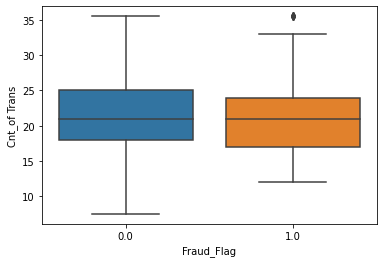

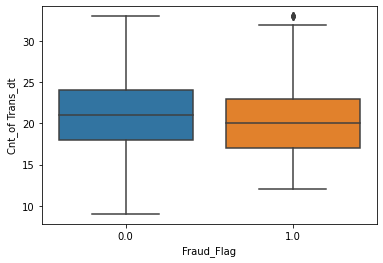

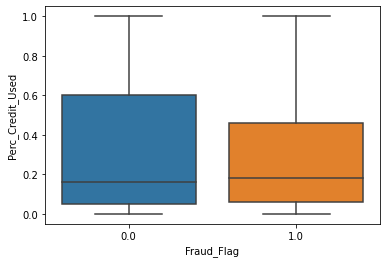

In [28]:
for i in df_master[features].columns:
    plt.figure()
    sns.boxplot(x="Fraud_Flag", y=i, data=df_master)

The distribution of most of the variables are similar across 0 and 1 fraud flag except the transaction value. This might be a good predictor.

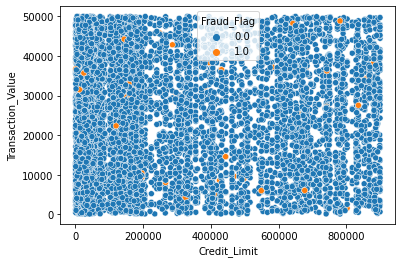

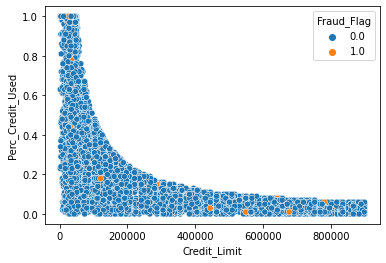

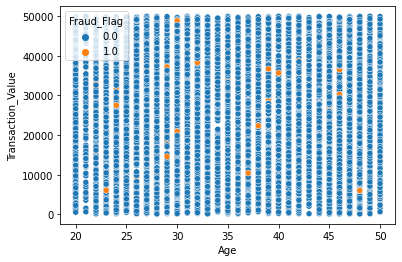

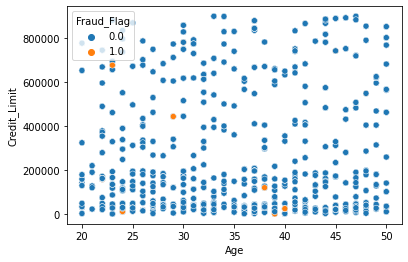

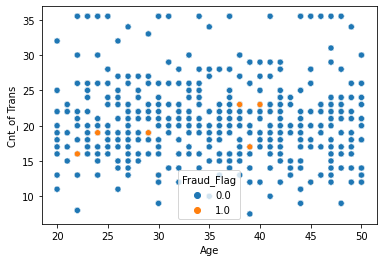

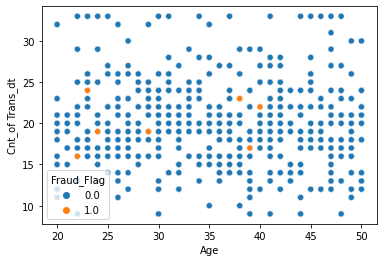

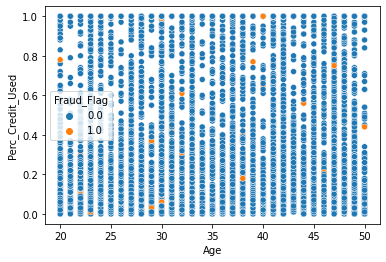

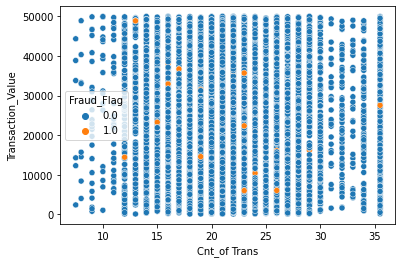

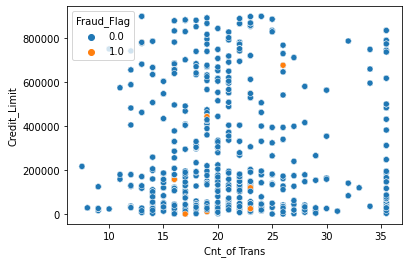

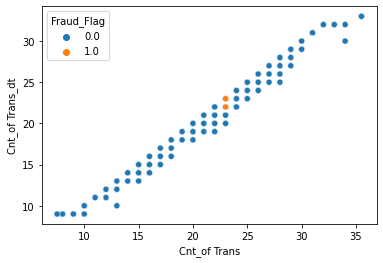

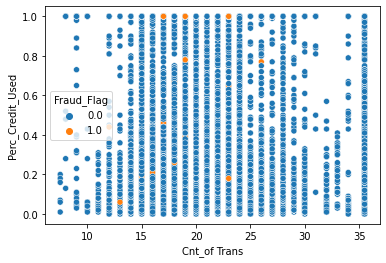

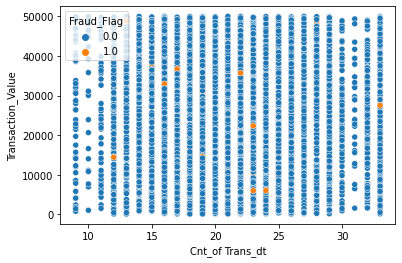

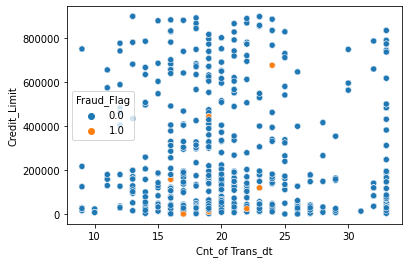

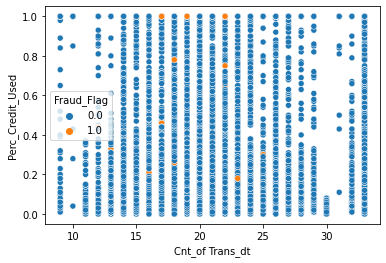

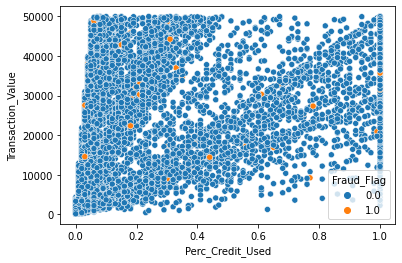

In [29]:
for i in df_master[features].columns:
    for j in df_master[features].columns:
        if (i!=j) and (i<j):
            plt.figure()
            sns.scatterplot(data=df_master, x=i, y=j, hue='Fraud_Flag')


We dont see any differentiating factor from the above graphs


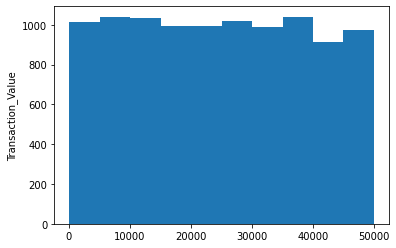

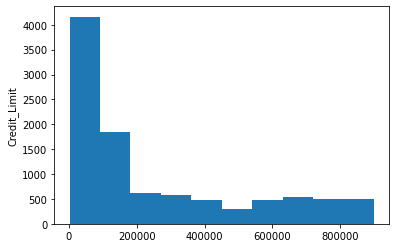

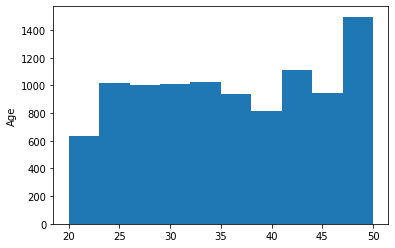

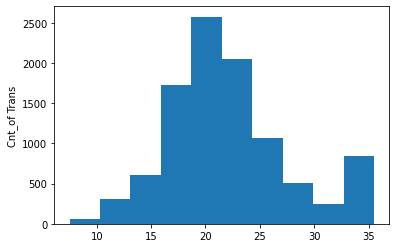

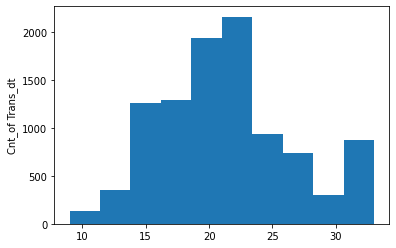

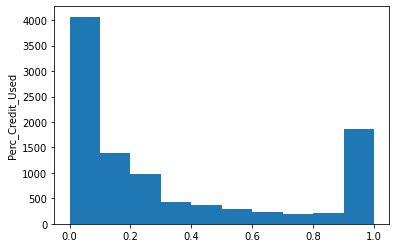

<Figure size 432x288 with 0 Axes>

In [30]:
for i in df_master[['Transaction_Value', 'Credit_Limit', 'Age', 'Cnt_of Trans', 'Cnt_of Trans_dt', 'Perc_Credit_Used']].columns:
    df_master[i].plot.hist(by=None, bins=10)
    plt.ylabel(i)
    plt.figure()

We see that for most customers the credit limit is on the lower side. Also the customers in age group are transacting more.


Also to mitigate the problem of skewness in the Credit_Limit we are doing a log transformation to it

In [31]:
df_master['Credit_Limit_log'] = np.log(df_master['Credit_Limit'])


                   Transaction_Value  ...  Perc_Credit_Used
Transaction_Value           1.000000  ...          0.387414
Credit_Limit               -0.006661  ...         -0.634123
Age                        -0.001739  ...          0.086128
Cnt_of Trans               -0.004424  ...          0.003648
Cnt_of Trans_dt            -0.006373  ...          0.011859
Perc_Credit_Used            0.387414  ...          1.000000

[6 rows x 6 columns]


[Text(0.5, 0, 'Transaction_Value'),
 Text(1.5, 0, 'Credit_Limit'),
 Text(2.5, 0, 'Age'),
 Text(3.5, 0, 'Cnt_of Trans'),
 Text(4.5, 0, 'Cnt_of Trans_dt'),
 Text(5.5, 0, 'Perc_Credit_Used')]

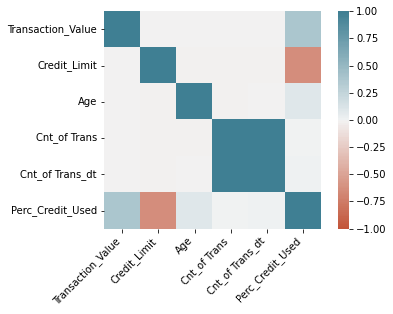

In [32]:
corr_data = df_master[features]
corr = corr_data.corr()
print(corr)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

There is no correlation between the original variables, but as expected there is correlation between derived variable.


## Variable selection and transformation


Weight of Evidence (WOE) and Information Value (IV) for continuous variables

In [33]:
def calculate_woe_iv(dataset, feature, target):
    new_var = col+'_bin'
    dataset[new_var] = pd.qcut(dataset[feature], 10, labels = False, duplicates='drop')
    result = dataset.groupby(new_var).agg({col: ['count', 'min', 'max']})
    print(result)
    print('\n')

    lst = []
    for i in range(dataset[new_var].nunique()):
        val = list(dataset[new_var].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[new_var] == val].count()[new_var],
            'Good': dataset[(dataset[new_var] == val) & (dataset[target] == 0)].count()[new_var],
            'Bad': dataset[(dataset[new_var] == val) & (dataset[target] == 1)].count()[new_var]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='Value')
    return dset, iv

In [34]:
#features = ['order_amount', 'customer_credit_score', 'customer_age']
for col in features:
    print('WoE and IV for column: ', col)
    woe_df, iv = calculate_woe_iv(df_master, col, 'Fraud_Flag')
    print(woe_df)
    print('IV score: {:.2f}'.format(iv))
    print('\n')

WoE and IV for column:  Transaction_Value
                      Transaction_Value                  
                                  count      min      max
Transaction_Value_bin                                    
0                                  1000    103.0   5022.0
1                                  1000   5025.0   9816.0
2                                  1000   9822.0  14613.0
3                                  1000  14620.0  19638.0
4                                  1000  19646.0  24720.0
5                                  1000  24721.0  29538.0
6                                  1000  29539.0  34661.0
7                                  1000  34668.0  39476.0
8                                  1000  39478.0  44854.0
9                                  1000  44872.0  49995.0


   Value   All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
5      0  1000   996    4    0.100698   0.036697  1.009420  0.064603
3      1  1000   985   15    0.099585   0.137615 -0.323441  0.01

We can see that the IV value for Cnt_of Trans_dt, Perc_Credit_Used_bin is lower than , and the WOE for different bins are not directional. As such, order_amount may not be a very important predictor.


Transaction value score has a high IV value


For Customer age, we can create three different bins based on the WOE values.

In [35]:
df_master['age_less30'] = np.where(df_master['Age']<=30, 1, 0)
df_master['age_btw30_45'] = np.where((df_master['Age']>30) &(df_master['Age']<45), 1, 0)
df_master['age_more45'] = np.where(df_master['Age']>=45, 1, 0)     
#df_master['cs_age'] = df_master['customer_credit_score']*df_master['age_more44']

## Weight of Evidence (WOE) and Information Value (IV) for categorical variables

In [36]:
def calculate_woe_iv_cat(dataset, new_var, target):
    #new_var = col+'_bin'
    #dataset[new_var] = pd.qcut(dataset[feature], 10, labels = False, duplicates='drop')
    #result = dataset.groupby(feature).agg({col: ['count', 'min', 'max']})
    #print(result)
    #print('\n')
    lst = []
    for i in range(dataset[new_var].nunique()):
        val = list(dataset[new_var].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[new_var] == val].count()[new_var],
            'Good': dataset[(dataset[new_var] == val) & (dataset[target] == 0)].count()[new_var],
            'Bad': dataset[(dataset[new_var] == val) & (dataset[target] == 1)].count()[new_var]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='WoE')
    return dset, iv

In [37]:
features = ['Transaction_Segment', 'Card_Family']
for col in features:
    print('WoE and IV for column: ', col)
    woe_df, iv = calculate_woe_iv_cat(df_master, col, 'Fraud_Flag')
    print(woe_df)
    print('IV score: {:.2f}'.format(iv))
    print('\n')

WoE and IV for column:  Transaction_Segment
    Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE        IV
11  SEG11  659   644   15    0.065110   0.137615 -0.748384  0.054262
10  SEG23  708   696   12    0.070367   0.110092 -0.447590  0.017780
5   SEG21  633   623   10    0.062987   0.091743 -0.376071  0.010815
8   SEG22  632   623    9    0.062987   0.082569 -0.270711  0.005301
3   SEG17  651   643    8    0.065009   0.073394 -0.121329  0.001017
1   SEG16  667   659    8    0.066626   0.073394 -0.096751  0.000655
12  SEG24  669   661    8    0.066828   0.073394 -0.093720  0.000615
2   SEG14  623   617    6    0.062380   0.055046  0.125077  0.000917
13  SEG20  668   662    6    0.066930   0.055046  0.195473  0.002323
14  SEG15  683   677    6    0.068446   0.055046  0.217879  0.002920
7   SEG12  695   689    6    0.069659   0.055046  0.235449  0.003441
4   SEG13  679   675    4    0.068244   0.036697  0.620386  0.019571
6   SEG18  682   678    4    0.068547   0.036697  0.624820 

Based on WOE values, we are creating dummies for multiple transaction segments together

## SMOTE: Synthetic Minority Oversampling TEchnique
Smote is used to solve the problem of unbalanced problem by synthetically generating data for class with lower population.



In [38]:
features = ['Transaction_Value','Age']
from imblearn.over_sampling import SMOTE
seed = 100
X = df_master[features]
y = df_master['Fraud_Flag']
sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=seed)
X, y = sm.fit_resample(X, y)
df1 = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1)
df1.columns =  ['Transaction_Value', 'Age', 'Fraud_Flag']

Distribution of response variable post application of SMOTE


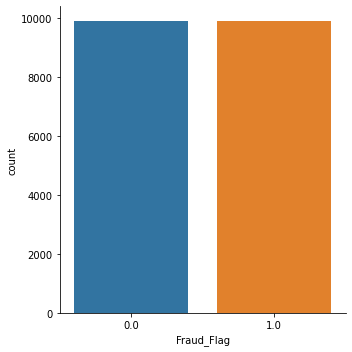

In [39]:
sns.catplot(x="Fraud_Flag", kind="count", data=df1)

## Machine Learning Algorithms
We created a function that takes in input data, predictors, dependent variable and model. It outputs the optimal probability threshold based on f1 score, and calculates the accuracy, recall and precision at the optimal threshold level. It also plots the ROC curve.

In [77]:
def get_f1_score(y_act, y_probability, p, beta):
    '''
    Parameters
    --------------------------------------------------
    :y_act:            actual reponse data 
    :y_probability:    probability score
    :p:                threshold
    :beta:             value to weight recall vs recall 
    '''
    y_pred = np.where(y_probability > p, 1, 0)
    acc_score = accuracy_score(y_act, y_pred)
    rec_score = recall_score(y_act, y_pred)
    prec_score = precision_score(y_act, y_pred)
    #fone_score = (rec_score*prec_score)/(rec_score*.1+prec_score*.9
    f_beta_score = (1+beta**2) * ((rec_score*prec_score) / (beta**2*prec_score + rec_score))                                  
    #fone_score = f1_score(y_act, y_pred)
    cm = confusion_matrix(y_act, y_pred, labels = [0,1])
    return p, acc_score, rec_score, prec_score, f_beta_score, cm, y_pred

def get_ROC_curve(y_act, y_probability):
    '''
    Parameters
    --------------------------------------------------
    :y_act:            actual reponse data
    :y_probability:    probability score
    '''
    fpr, tpr, thresholds = roc_curve(y_act, y_probability)
    roc_auc = roc_auc_score(y_act, y_probability)
    plt.figure()
    plt.plot(fpr, tpr, label = "area is %.2f" %roc_auc)
    plt.plot([0,1], [0,1], "--r")
    plt.xlim = [0,1.5]
    plt.legend(loc = "lower right")
    plt.title("ROC Curve")
    
def run_classification_model(data_1, feature_var, target, model, beta, smote_f = False):  
    '''
    Parameters
    --------------------------------------------------
    :data_1:          datset needed
    :feature_var:     feature names
    :target:          response variable
    :model:           type of model(RF/logistic) 
    :beta:            value to weight recall vs recall
    :smote_f:         apply spmote for the imbalanced dataset
    '''
    X_train, X_test_validation, y_train, y_test_validation = train_test_split(data_1[feature_var], data_1[target], test_size=0.6, stratify=data_1[target], random_state = 1)
    X_validation, X_test, y_validation, y_test = train_test_split(X_test_validation, y_test_validation, test_size=0.5, stratify=y_test_validation, random_state = 1)
    if smote_f == True:
        sm = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=seed)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    model = model.fit(X_train, y_train)
    y_proba_validation = model.predict_proba(X_validation)[:,1]
    get_ROC_curve(y_validation, y_proba_validation)
    opt_f1 = 0
    for i in range(0,100):
        cut_off, acc_sc, recall, precision, f1_sc, cm, y_pred = get_f1_score(y_validation, y_proba_validation, i/100, beta)
    #print("Threshold: %.2f" %(i/100), "f1 score: %.2f" %f1_sc, "recall: %.2f" %recall, "precision: %.2f" %precision)
        if opt_f1 < f1_sc:
            opt_f1, cut_off_op, recall_op, prc_op, acc_op = f1_sc, cut_off, recall, precision, acc_sc
    print("The optimal cutoff is %.2f" %cut_off_op, "and the corresponding f1-score is %.2f" %opt_f1)
    y_proba_test = model.predict_proba(X_test)[:,1]
    cut_off, acc_score, rec_score, precision_score, f1_score, cm, y_pred = get_f1_score(y_test, y_proba_test, cut_off_op, beta)
    print("Test Accuracy %.2f" %acc_score)
    print("Test Recall %.2f" %rec_score)
    print("Test Precision %.2f" %precision_score)
    print("Test Confusion Matrix")
    print(cm)
    return y_pred, cut_off, cm


Derive the feature importance using Random Forest Classifier

In [71]:
def get_feature_importance(data_1, feature_var, target, model):    
    X_train, X_test, y_train, y_test = train_test_split(data_1[feature_var], data_1[target], test_size=0.3, stratify=data_1[target], random_state = 1)
    model.fit(X_train, y_train)
    wts = model.feature_importances_
    fimp = pd.DataFrame({'importance':(wts*100).round(2), 'feature':feature_var})
    print(fimp[fimp['importance']>0].sort_values('importance', ascending=False).reset_index(drop=True))

In [72]:
features = ['Transaction_Value', 'Credit_Limit', 'Age', 'No_of_Cards', 'Cnt_of Trans', 'Cnt_of Trans_dt', 
            'Perc_Credit_Used', 'Card_Family_G', 'Card_Family_Pr', 'Customer_Segment_G', 'Customer_Segment_Pr']
model = RandomForestClassifier(n_estimators=10, min_samples_split=200)
get_feature_importance(df_master, features, 'Fraud_Flag', model)

   importance             feature
0       50.80   Transaction_Value
1       13.56                 Age
2       12.64        Credit_Limit
3        8.73    Perc_Credit_Used
4        7.04        Cnt_of Trans
5        4.30     Cnt_of Trans_dt
6        1.20  Customer_Segment_G
7        0.86      Card_Family_Pr
8        0.48         No_of_Cards
9        0.40       Card_Family_G


We can use the important variables based on the feature importance values in our model to improve the accuracy

We are using the beta as 2 ie, giving double importance to recall over precision. This is because for a fraud detection problem, its more important to predict all the fraud transaction correctly at the cost of precision

In [73]:
features = ['Transaction_Value', 'Credit_Limit', 'Age', 'Cnt_of Trans', 'Cnt_of Trans_dt', 'Perc_Credit_Used']

The optimal cutoff is 0.02 and the corresponding f1-score is 0.06
Test Accuracy 0.82
Test Recall 0.18
Test Precision 0.01
Test Confusion Matrix
[[2451  516]
 [  27    6]]


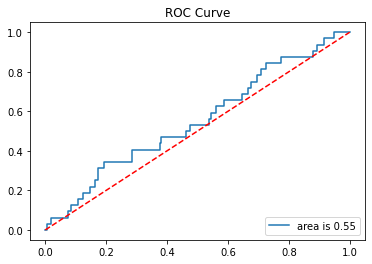

In [83]:
model = LogisticRegression(penalty = 'l2')
y_pred, cut_off_op, cm = run_classification_model(df_master, features, 'Fraud_Flag', model, 2, smote_f=False)


The optimal cutoff is 0.50 and the corresponding f1-score is 0.02
Test Accuracy 0.41
Test Recall 0.67
Test Precision 0.01
Test Confusion Matrix
[[1218 1749]
 [  11   22]]


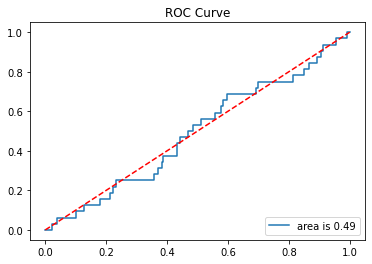

In [85]:
model = LogisticRegression(penalty = 'l2')
y_pred, cut_off_op, cm = run_classification_model(df_master, features, 'Fraud_Flag', model, 1, smote_f=True)


The optimal cutoff is 0.01 and the corresponding f1-score is 0.06
Test Accuracy 0.50
Test Recall 0.48
Test Precision 0.01
Test Confusion Matrix
[[1482 1485]
 [  17   16]]


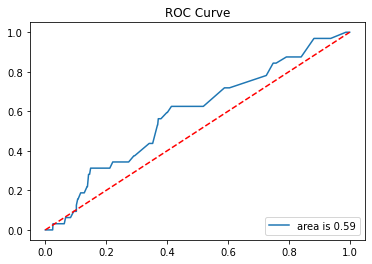

In [86]:
model = RandomForestClassifier(n_estimators=10,  min_samples_split=2000)
y_pred, cut_off_op, cm = run_classification_model(df_master, features, 'Fraud_Flag', model, 2, smote_f=False)


The optimal cutoff is 0.53 and the corresponding f1-score is 0.06
Test Accuracy 0.72
Test Recall 0.33
Test Precision 0.01
Test Confusion Matrix
[[2162  805]
 [  22   11]]


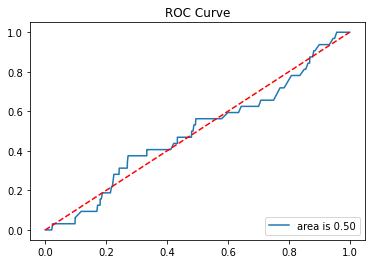

In [87]:
model = RandomForestClassifier(n_estimators=10,  min_samples_split=2000)
y_pred, cut_off_op, cm = run_classification_model(df_master, features, 'Fraud_Flag', model, 2, smote_f=True)